# Predykcja awarii maszyn

Tytuł przedmiotu: Analiza danych i symulacje w języku Python

Imię i nazwisko: Kamil Olszewski

Data: 04.12.2024

## Opis organizacji

Średniej wielkości firma z kilkoma liniami produkcyjnymi, specjalizująca się w produkcji przemysłowej. Produkty wytwarzane przez maszyny, które są kluczowe w procesie produkcji.

## Opis problemu

Jakie czynniki (parametry czujników) wskazują na ryzyko awarii maszyn?

#### Założenia:
Dane z czujników są dokładne, dane o awariach maszyn są dostępne w historycznych zestawach danych.

#### Dostępne dane:
- Historyczne dane z czujników zamontowanych w maszynach:
    - Temperatura (Temperature)
    - Wibracja (Vibration)
    - Ciśnienie (Pressure)
    - Obroty (RPM)
    - Wilgotność (Humidity)
    - Poziom Oleju (Oil_Level)
    - Ciśnienie Oleju (Oil_Pressure)
    - Czas Pracy (Working_Hours)
    - Temperatura Otoczenia (Ambient_Temperature)
    - Obciążenie (Load)
- Wiek maszyny (Machine_Age)
- Awarie maszyn: czy i kiedy wystąpiły (Failure) - 0 brak awarii, 1 - awaria
-
#### Cel:
Przewidywanie awarii maszyn na podstawie danych z czujników, co może pomóc w zapobieganiu nieplanowanym przestojom i optymalizacji kosztów konserwacji.

#### Wynik:
Zbudowanie modelu predykcyjnego, który może przewidzieć awarie maszyn na podstawie parametrów takich jak temperatura, wibracje, ciśnienie itp.

## Analiza

In [82]:
%reset -f

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import PartialDependenceDisplay
from xgboost import XGBClassifier


In [84]:
# Załadowanie danych z pliku CSV
df = pd.read_csv('machine_failure_data.csv')

print(f'Plik z danymi został załadowany')

Plik z danymi został załadowany


#### Podstawowa analiza danych

In [85]:
# Informacje o danych
print("Informacje o danych:")
df.info()

Informacje o danych:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31050 entries, 0 to 31049
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Machine_ID           31050 non-null  object 
 1   Date                 31050 non-null  object 
 2   Temperature          31050 non-null  float64
 3   Vibration            31050 non-null  float64
 4   Pressure             31050 non-null  float64
 5   RPM                  31050 non-null  float64
 6   Humidity             31050 non-null  float64
 7   Oil_Level            31050 non-null  float64
 8   Oil_Pressure         31050 non-null  float64
 9   Working_Hours        31050 non-null  float64
 10  Ambient_Temperature  31050 non-null  float64
 11  Load                 31050 non-null  float64
 12  Machine_Age          31050 non-null  int64  
 13  Failure              31050 non-null  int64  
dtypes: float64(10), int64(2), object(2)
memory usage: 3.3+ MB


In [86]:
# Statystyki opisowe
print("\nStatystyki opisowe:")
df.describe()


Statystyki opisowe:


,Temperature,Vibration,Pressure,RPM,Humidity,Oil_Level,Oil_Pressure,Working_Hours,Ambient_Temperature,Load,Machine_Age,Failure
count,31050.000000,31050.000000,31050.000000,31050.000000,31050.000000,31050.000000,31050.000000,31050.000000,31050.000000,31050.000000,31050.000000,31050.000000
mean,75.018292,0.500005,100.077612,1499.130879,50.036852,79.962212,199.992448,40213.178468,21.999676,70.135570,7.408696,0.104316
std,4.971237,0.100257,10.003512,199.150485,9.984579,10.042820,14.938867,18480.792950,3.970790,9.943388,3.609241,0.305674
min,55.003339,0.104826,59.964019,699.974124,8.268545,39.459499,137.633992,9175.779982,4.383144,31.829909,2.000000,0.000000
25%,71.686149,0.432224,93.353049,1364.922401,43.367071,73.236703,189.904456,25224.485799,19.332502,63.452155,5.000000,0.000000
50%,75.006680,0.500107,100.026939,1499.009105,50.005484,79.929094,199.997653,36348.116921,22.032595,70.127943,7.000000,0.000000
75%,78.334268,0.567735,106.888936,1633.006753,56.721100,86.661182,210.026482,55361.525884,24.673939,76.869262,11.000000,0.000000
max,97.921759,0.897687,139.050558,2256.953906,87.987021,126.167263,259.824468,81791.649081,37.136545,113.054900,14.000000,1.000000


In [87]:
# Sprawdzenie brakujących wartości
print("\nBrakujące wartości:")
df.isnull().sum()


Brakujące wartości:


Machine_ID             0
Date                   0
Temperature            0
Vibration              0
Pressure               0
RPM                    0
Humidity               0
Oil_Level              0
Oil_Pressure           0
Working_Hours          0
Ambient_Temperature    0
Load                   0
Machine_Age            0
Failure                0
dtype: int64

In [88]:
# Wyświetlenie pierwszych 10 wierszy danych
print("\nPierwsze 10 wierszy danych:")
df.head(n=10)


Pierwsze 10 wierszy danych:


,Machine_ID,Date,Temperature,Vibration,Pressure,RPM,Humidity,Oil_Level,Oil_Pressure,Working_Hours,Ambient_Temperature,Load,Machine_Age,Failure
0,M4000_L01_6390,2022-01-01,65.621616,0.363322,106.363051,1318.655866,54.760426,93.036613,203.173805,19263.720546,24.388179,61.036648,4,0
1,M4000_L01_6390,2022-01-02,74.440061,0.621217,112.334968,1185.168943,56.379529,59.555770,216.042213,19276.744820,18.264949,77.842082,4,1
2,M4000_L01_6390,2022-01-03,74.247331,0.403444,101.504891,1477.315750,76.335282,69.749091,188.269283,19289.557065,23.695772,78.727051,4,0
3,M4000_L01_6390,2022-01-04,86.436130,0.513575,106.080897,1640.996262,53.609234,65.330321,213.389442,19302.430826,21.578971,60.446536,4,0
4,M4000_L01_6390,2022-01-05,79.813206,0.479031,92.259571,1428.044371,57.240833,77.442354,212.748818,19316.567184,16.754703,61.296950,4,0
5,M4000_L01_6390,2022-01-06,72.466784,0.694512,98.466635,1318.602555,41.826458,75.168773,191.452575,19328.826753,13.633601,82.637405,4,0
6,M4000_L01_6390,2022-01-07,70.769915,0.417751,110.867270,1700.997376,45.582340,79.158349,218.555241,19342.617886,16.294084,73.380227,4,0
7,M4000_L01_6390,2022-01-08,84.872856,0.715873,112.317784,1457.135103,43.108058,87.278331,190.713960,19356.213183,23.424639,69.781191,4,0
8,M4000_L01_6390,2022-01-09,77.562119,0.554349,100.280995,1260.582587,57.896728,84.314895,183.548716,19369.607847,19.270794,78.875116,4,0
9,M4000_L01_6390,2022-01-10,78.027416,0.542801,75.303011,1596.395828,59.264564,71.624186,210.157791,19382.522047,29.489276,73.963739,4,0


#### Wizualizacja danych

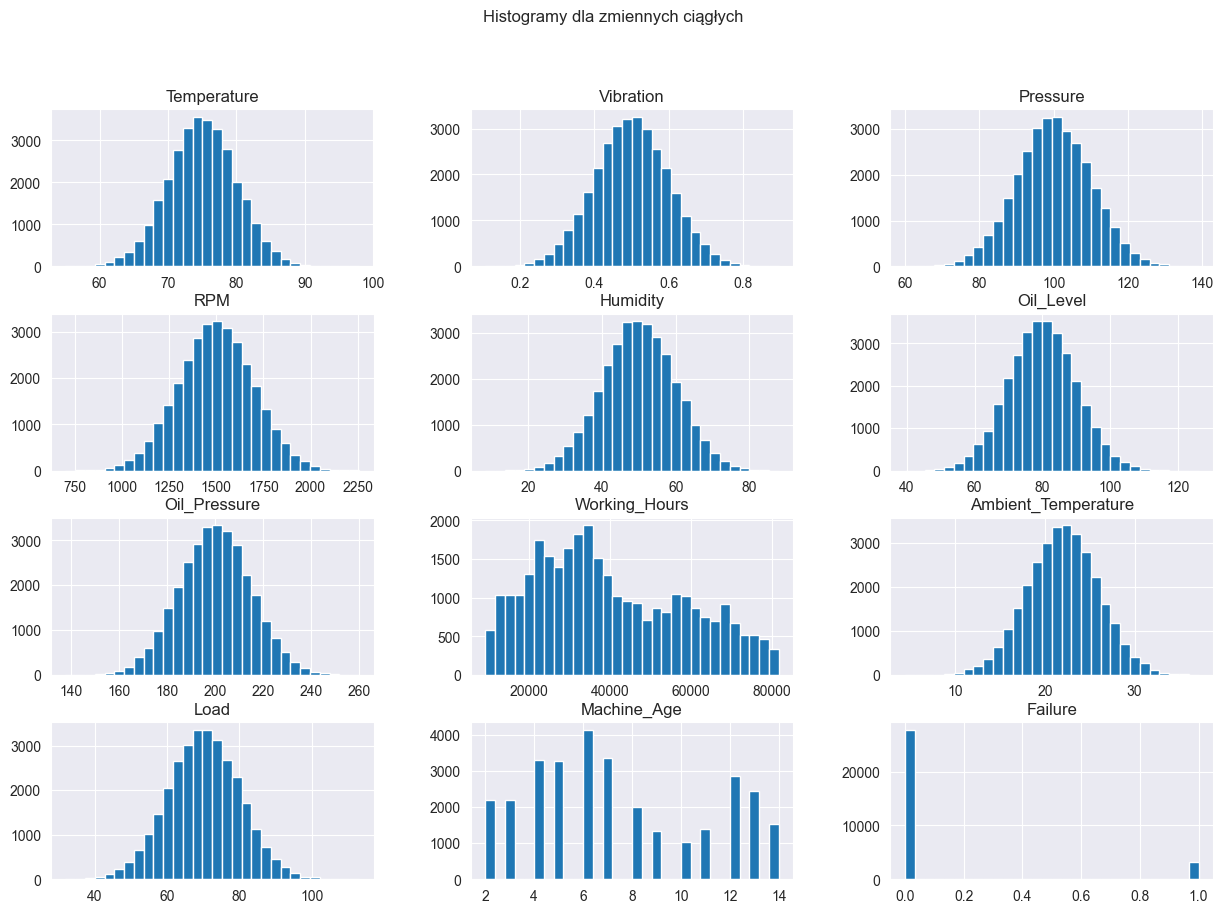

In [89]:
# Histogramy dla zmiennych ciągłych
numerical_cols = df.select_dtypes(include=[np.number]).columns

df[numerical_cols].hist(bins=30, figsize=(15, 10))
plt.suptitle('Histogramy dla zmiennych ciągłych')
plt.show()

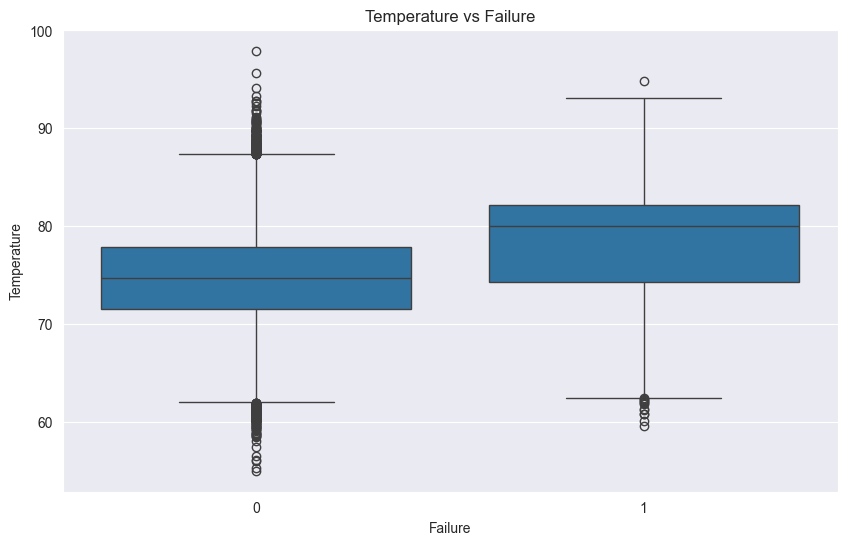

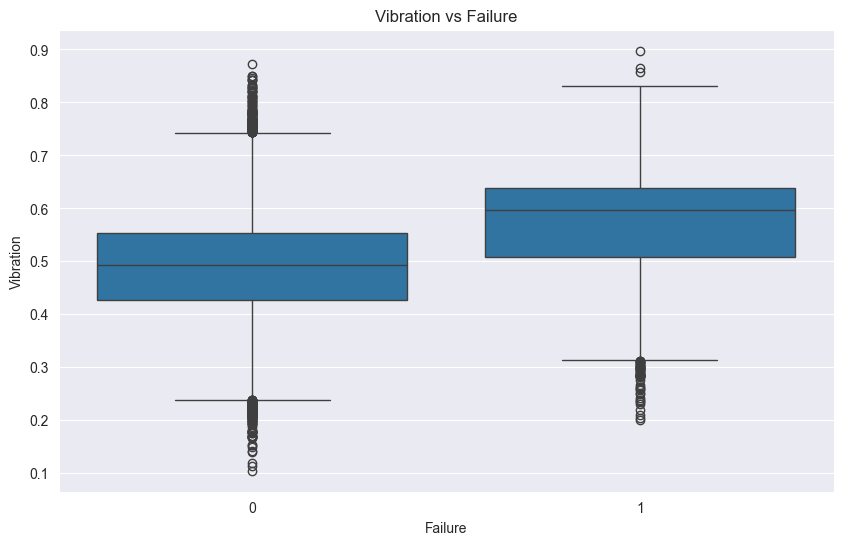

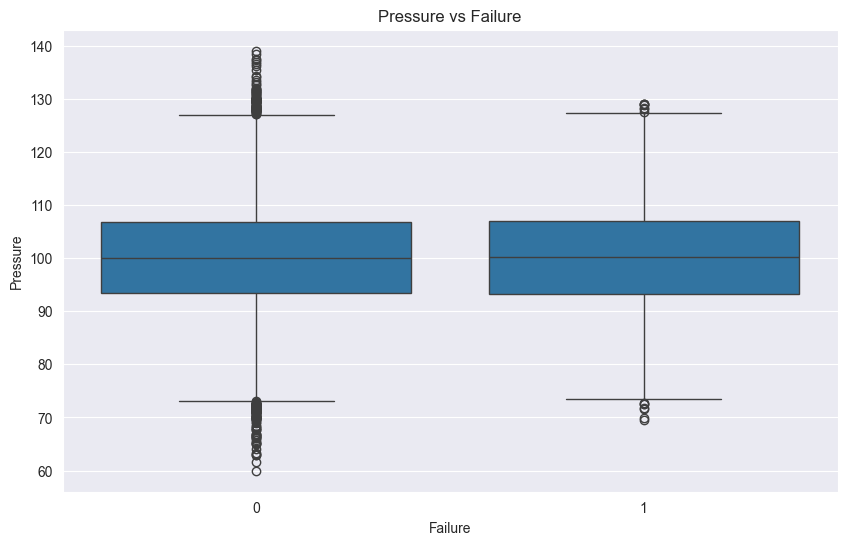

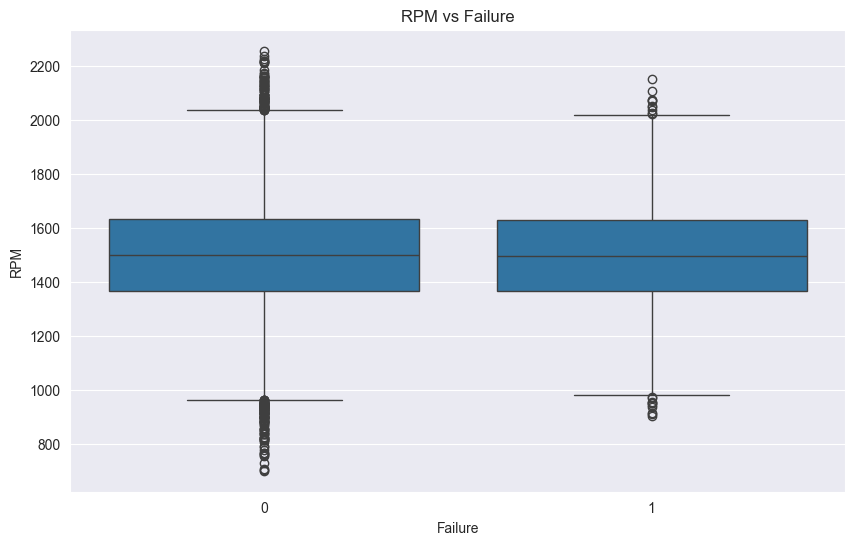

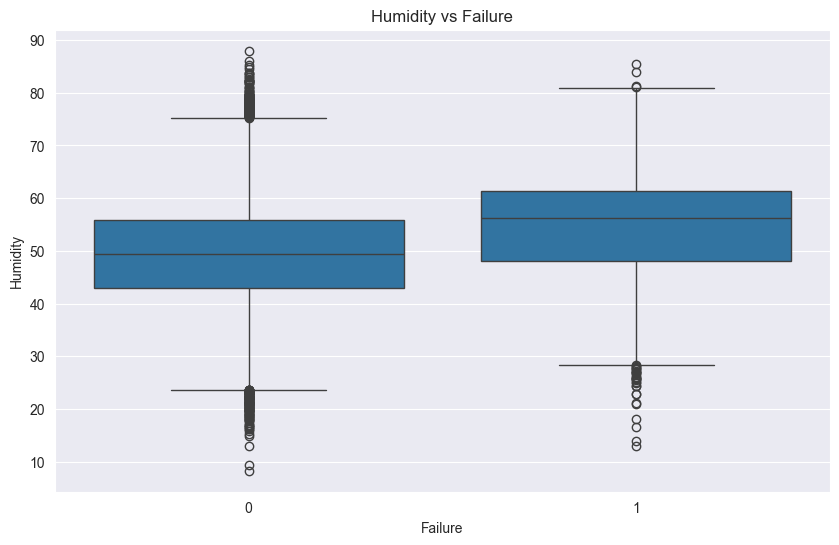

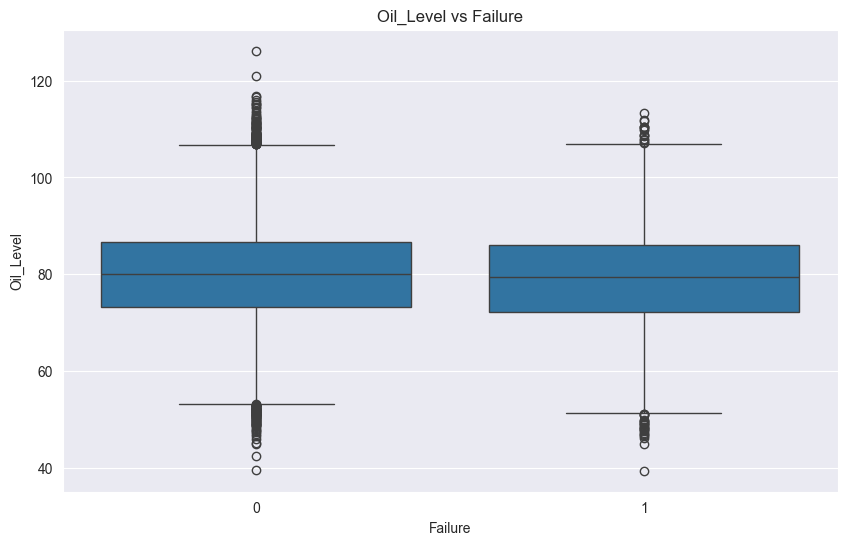

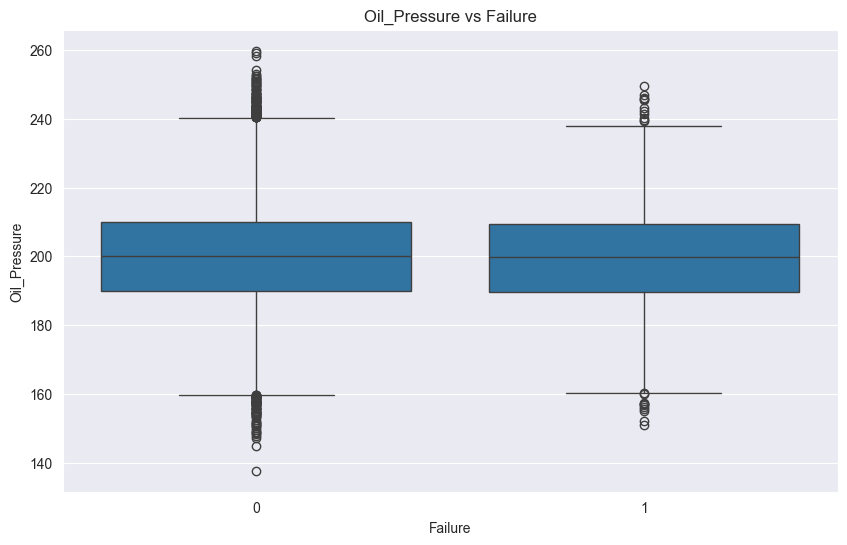

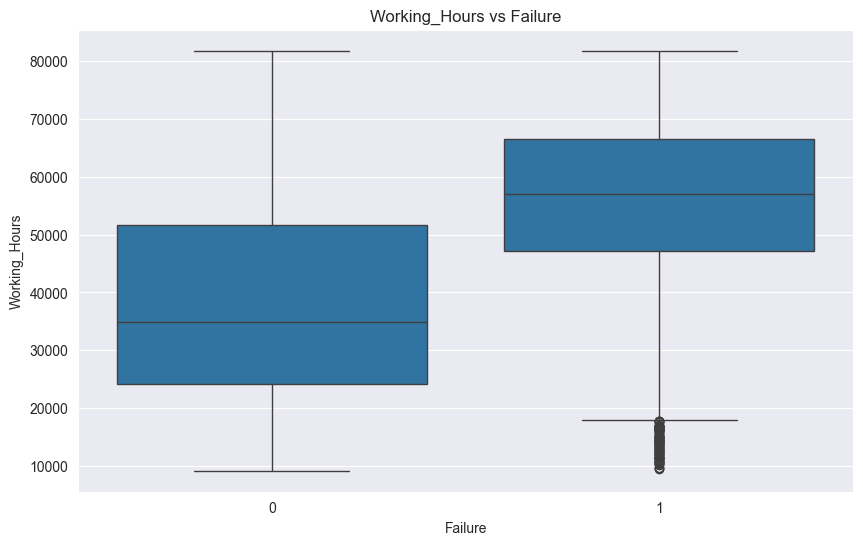

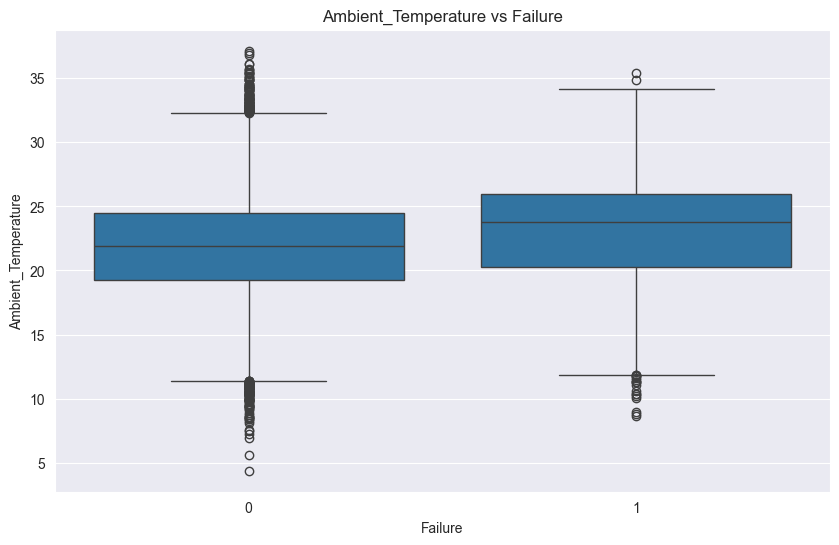

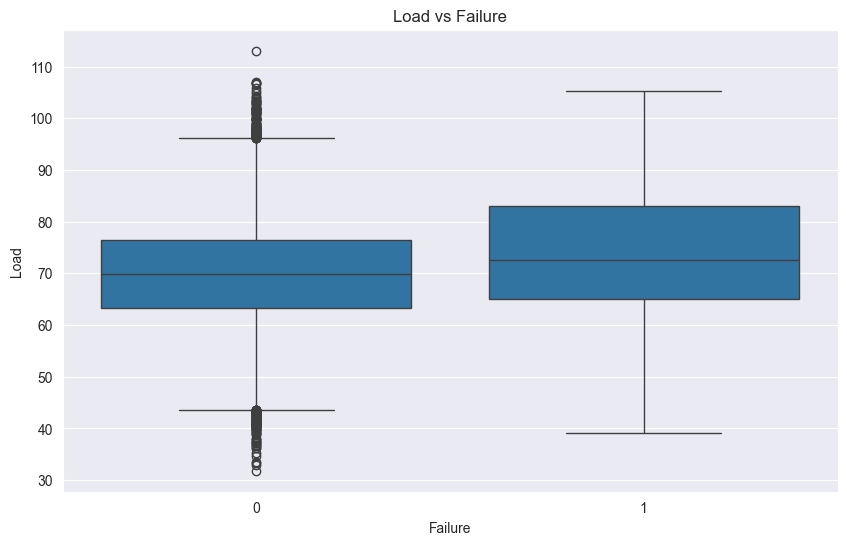

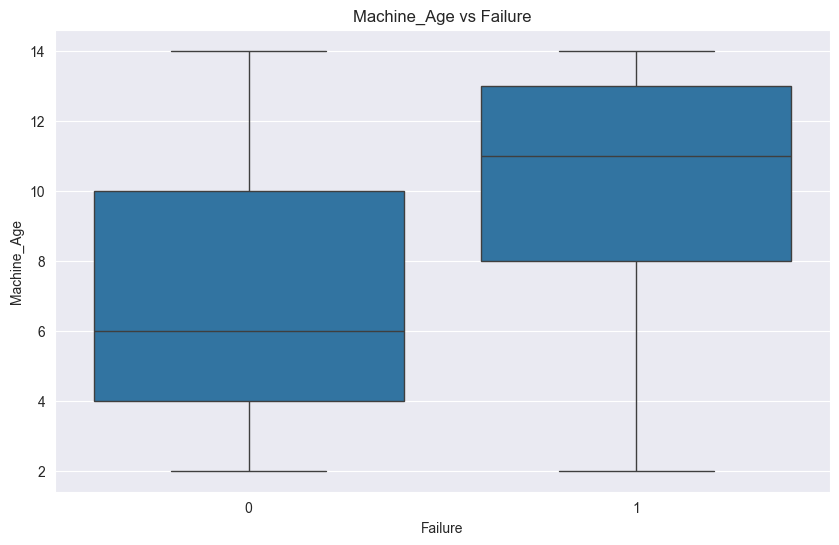

In [90]:
# Wykresy zależności
y = ['Temperature', 'Vibration', 'Pressure', 'RPM', 'Humidity', 'Oil_Level', 'Oil_Pressure', 'Working_Hours', 'Ambient_Temperature', 'Load', 'Machine_Age']
x = 'Failure'

for element in y:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x=x, y=element)
    plt.title(f'{element} vs {x}')
    plt.show()

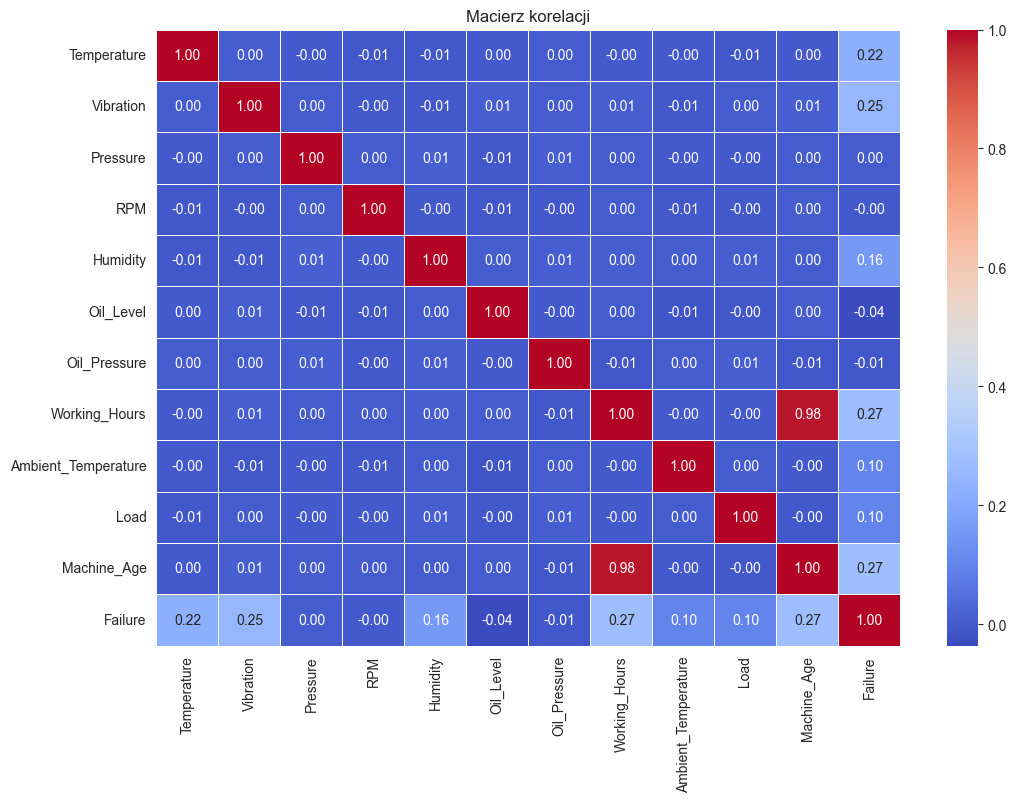

In [91]:
# Macierz korelacji
correlation_matrix = df[numerical_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Macierz korelacji')
plt.show()


#### Wnioski z tego wykresu:
Na podstawie tej macierzy korelacji można wskazać następujące czynniki, które mogą wskazywać na ryzyko awarii maszyn:
- Wibracje (Vibration), (korelacja 0.25): Wyższe wibracje mogą sugerować większe ryzyko awarii.
- Temperatura (Temperature), (korelacja 0.22): Wyższa temperatura może zwiększać ryzyko awarii, ale związek nie jest silny.
- Obciążenie (Load), (korelacja 0.27): Wyższe obciążenie może zwiększać ryzyko awarii.
- Wiek maszyny (Machine_Age), (korelacja 0.27): Starsze maszyny mają wyższe ryzyko awarii.

Wnioski te nie są jednoznaczne, ponieważ korelacje są stosunkowo słabe. Aby dokładniej przewidywać ryzyko awarii, przeprowadzę analizę predykcyjną, która uwzględni wiele czynników jednocześnie.

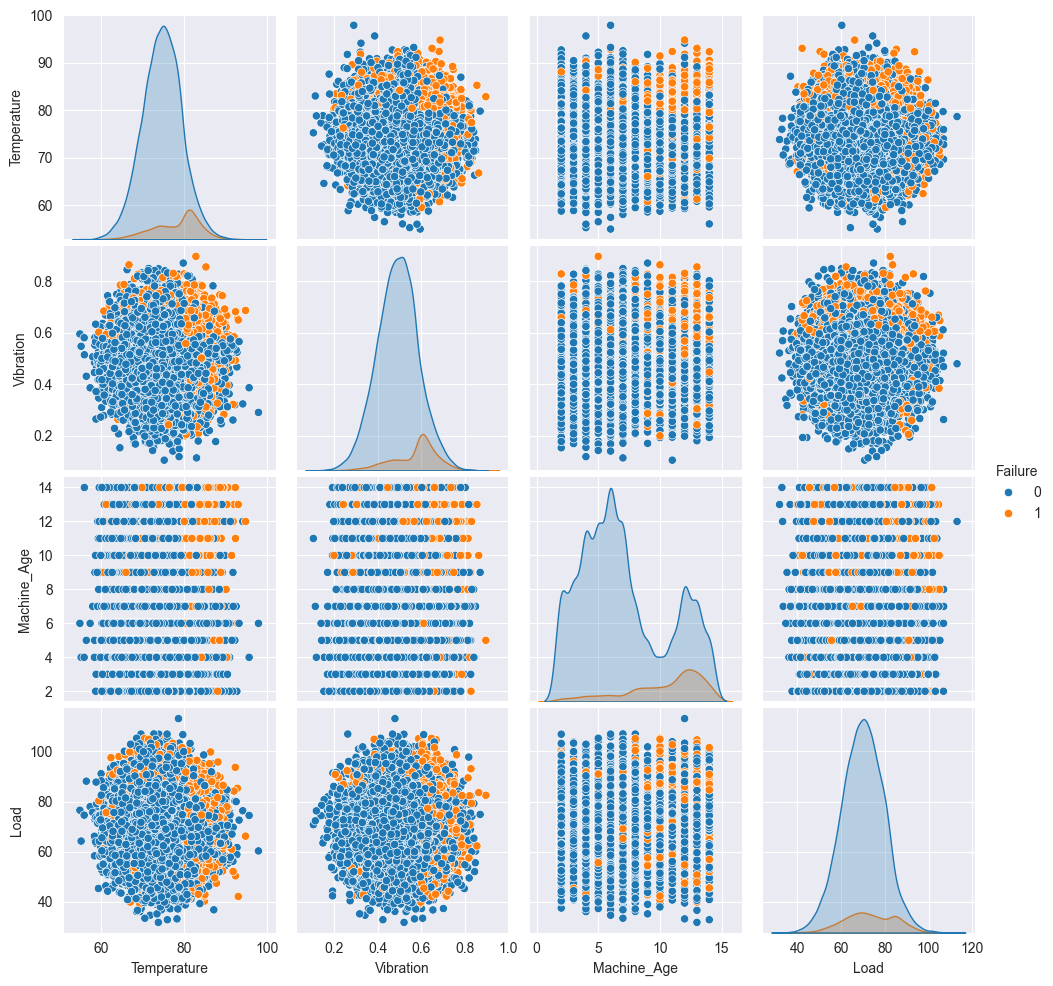

In [92]:
# Wykres par dla wybranych zmiennych
sns.pairplot(df[['Temperature', 'Vibration', 'Machine_Age', 'Load', 'Failure']], hue='Failure')
plt.show()


#### Wnioski z tego wykresu

- Wysoka temperatura i niższe wibracje są powiązane z większym ryzykiem awarii.
- Obciążenie ma wyraźny wpływ na awarie – maszyny z wyższym obciążeniem mają większą tendencję do awarii.
- Wiek maszyny: Starsze maszyny mogą być bardziej narażone na awarie, ale nie ma wyraźnej zależności z temperaturą i wibracjami.

Relacje między parami zmiennych:
- Temperatura vs Wibracje: Dla maszyn z awarią widać, że wyższe temperatury są związane z niższymi wibracjami. W przypadku maszyn bez awarii temperatura i wibracje wydają się bardziej rozproszone, co może sugerować, że same te zmienne nie są wystarczające do przewidywania awarii.
- Temperatura vs Wiek maszyny: Widać, że starsze maszyny mają tendencję do wyższych temperatur, ale zarówno dla maszyn z awarią, jak i bez awarii, temperatura w tym przypadku jest rozproszona.
- Wibracje vs Wiek maszyny: W przypadku maszyn z awarią, starsze maszyny mają wyższe wibracje. Warto zauważyć, że maszyny bez awarii mają niskie wibracje w szerokim zakresie wieku.
- Wibracje vs Obciążenie: Z wykresu wynika, że w przypadku niższych wibracji (poniżej 0.3) maszyny mogą być mniej obciążone, ale wyższe obciążenie jest związane z większymi wibracjami, co może sugerować związek między obciążeniem a ryzykiem awarii.

## Analiza predykcyjna

Porównanie wyników modeli:
                              Accuracy Precision    Recall  F1-score  \
Logistic Regression           0.922705  0.765333   0.42268  0.544592   
Random Forest                 0.998068       1.0  0.982327  0.991085   
Support Vector Machine (SVM)  0.942673  0.835759  0.592047  0.693103   
Gradient Boosting (XGBoost)   0.998873       1.0  0.989691  0.994819   
K-Nearest Neighbors (KNN)     0.928341   0.85241  0.416789  0.559842   
Decision Tree                 0.998229       1.0    0.9838  0.991834   

                                      Confusion Matrix  
Logistic Regression           [[5443, 88], [392, 287]]  
Random Forest                   [[5531, 0], [12, 667]]  
Support Vector Machine (SVM)  [[5452, 79], [277, 402]]  
Gradient Boosting (XGBoost)      [[5531, 0], [7, 672]]  
K-Nearest Neighbors (KNN)     [[5482, 49], [396, 283]]  
Decision Tree                   [[5531, 0], [11, 668]]  


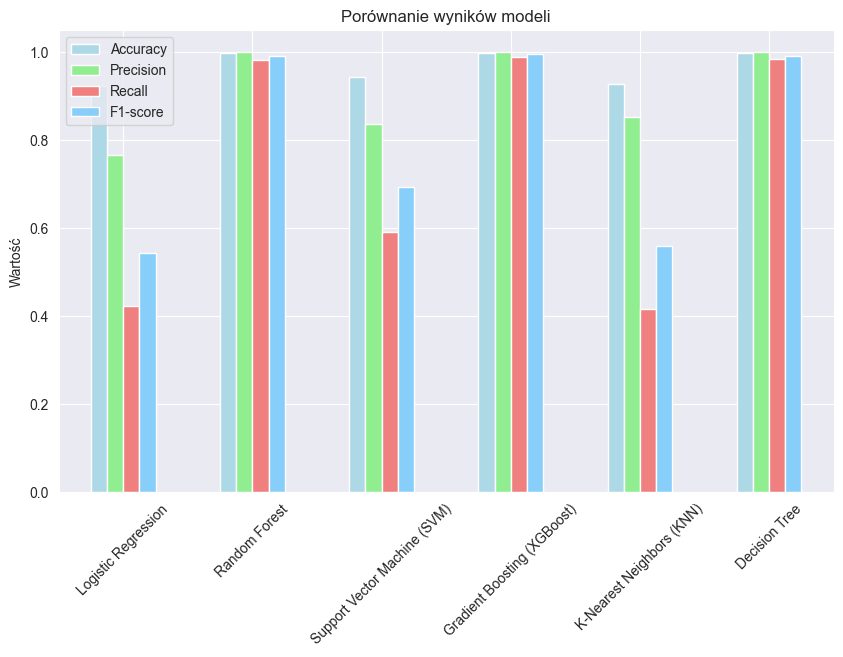

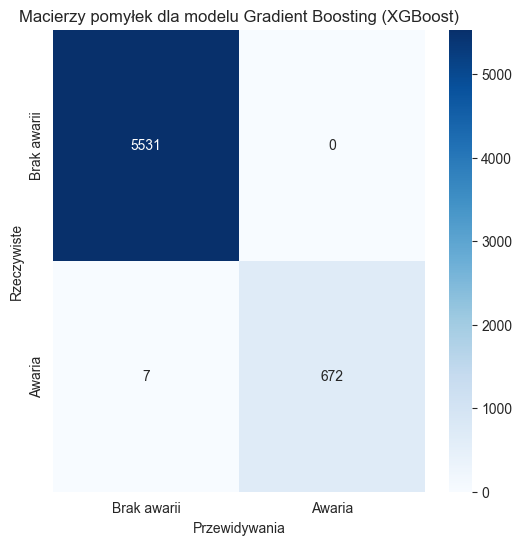


Wskaźniki klasyfikacji dla najlepszego modelu (Gradient Boosting (XGBoost)):
Precision: 1.0000
Recall: 0.9897
F1-score: 0.9948


In [93]:
# Wybór zmiennych wejściowych i wyjściowych
X = df[['Temperature', 'Vibration', 'Pressure', 'RPM', 'Humidity', 'Oil_Level', 'Oil_Pressure', 'Working_Hours', 'Ambient_Temperature', 'Load', 'Machine_Age']]
y = df['Failure']

# Podział danych na zbiór treningowy i testowy (80% trening, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizacja/standaryzacja
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definiowanie modeli
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Support Vector Machine (SVM)": SVC(random_state=42),
    "Gradient Boosting (XGBoost)": GradientBoostingClassifier(random_state=42),
    "K-Nearest Neighbors (KNN)": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
}

# Trenowanie i ocena modeli
results = {}

for model_name, model in models.items():
    # Trenowanie modelu
    model.fit(X_train_scaled, y_train)

    # Predykcje na zbiorze testowym
    y_pred = model.predict(X_test_scaled)

    # Ocena modelu
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Zapisanie wyników modelu
    results[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1,
        "Confusion Matrix": conf_matrix
    }

# Podsumowanie wyników dla każdego modelu
results_df = pd.DataFrame(results).T
print("Porównanie wyników modeli:")
print(results_df)

# Wizualizacja wyników – wykres słupkowy dla metryk
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
results_df[metrics].plot(kind='bar', figsize=(10, 6), color=['lightblue', 'lightgreen', 'lightcoral', 'lightskyblue'])
plt.title('Porównanie wyników modeli')
plt.ylabel('Wartość')
plt.xticks(rotation=45)
plt.show()

# Analiza macierzy pomyłek (Confusion Matrix) dla najlepszego modelu
results_df = results_df.apply(pd.to_numeric, errors='ignore')

best_model_name = results_df['F1-score'].idxmax()  # Wybór modelu z najwyższym F1-score
best_model = models[best_model_name]  # Użycie najlepszego modelu
y_pred_best = best_model.predict(X_test_scaled)

# Generowanie macierzy pomyłek
conf_matrix_best = confusion_matrix(y_test, y_pred_best)

# Wizualizacja macierzy pomyłek
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='Blues', xticklabels=['Brak awarii', 'Awaria'], yticklabels=['Brak awarii', 'Awaria'])
plt.title(f'Macierzy pomyłek dla modelu {best_model_name}')
plt.xlabel('Przewidywania')
plt.ylabel('Rzeczywiste')
plt.show()

# Wskaźniki klasyfikacji
TP = conf_matrix_best[1, 1]
FP = conf_matrix_best[0, 1]
TN = conf_matrix_best[0, 0]
FN = conf_matrix_best[1, 0]

# Precision, Recall, F1-score z macierzy pomyłek
precision_best = TP / (TP + FP)
recall_best = TP / (TP + FN)
f1_best = 2 * (precision_best * recall_best) / (precision_best + recall_best)

print(f"\nWskaźniki klasyfikacji dla najlepszego modelu ({best_model_name}):")
print(f"Precision: {precision_best:.4f}")
print(f"Recall: {recall_best:.4f}")
print(f"F1-score: {f1_best:.4f}")


#### Podsumowanie analizy predykcyjnej:
W analizie brałem pod uwagę 6 modeli klasyfikacyjnych, które były trenowane na danych dotyczących maszyn i ich awarii. Modele te to:
- Logistic Regression
- Random Forest
- Support Vector Machine (SVM)
- Gradient Boosting (XGBoost)
- K-Nearest Neighbors (KNN)
- Decision Tree

##### Wybór najlepszego modelu:
- F1-score był główną metryką, którą użyłem do wyboru najlepszego modelu. Na podstawie wyników, najlepszy model to Gradient Boosting (XGBoost), który uzyskał najwyższy F1-score: 0.9948.
- Wybór najlepszego modelu był również uzasadniony Precision (1.0000) i Recall (0.9897), które wskazują, że model bardzo dobrze rozróżniał przypadki awarii od braku awarii, minimalizując zarówno błędy fałszywie pozytywne, jak i fałszywie negatywne.


##### Metryki do oceny jakości modelu:
- Accuracy: Procent poprawnie sklasyfikowanych przypadków. Choć ta metryka była uwzględniona, nie była kluczowa ze względu na potencjalną nierównowagę klas (np. dużo więcej przypadków braku awarii niż awarii).
- Precision: Odsetek poprawnie przewidzianych awarii wśród wszystkich przewidywanych awarii. Precision = 1.0000 dla XGBoost wskazuje, że model nigdy nie pomylił braku awarii z awarią.
- Recall: Procent rzeczywistych awarii, które zostały poprawnie przewidziane przez model. Recall = 0.9897 dla XGBoost oznacza, że model wykrywa prawie wszystkie przypadki awarii.
- F1-score: Jest to średnia harmoniczna między precision a recall. Wybór tej metryki jest uzasadniony w kontekście niejednakowej liczby przypadków dla klasy "awaria" i "brak awarii". F1-score dla XGBoost wynosi 0.9948, co oznacza bardzo wysoką jakość modelu.

##### Podsumowanie wyników:

XGBoost okazał się najlepszym modelem, osiągając najwyższe wartości precision (1.0000), recall (0.9897) i F1-score (0.9948).
Random Forest także dał bardzo dobre wyniki, jednak nie osiągnął aż tak wysokiego F1-score jak XGBoost (0.9910).
Inne modele, takie jak Logistic Regression czy K-Nearest Neighbors (KNN), uzyskały znacznie niższe wartości recall i F1-score, co wskazuje na ich gorszą skuteczność w przewidywaniu awarii.

##### Wnioski:

Najlepszym modelem do przewidywania awarii maszyn jest Gradient Boosting (XGBoost), który zapewnia wysoką jakość predykcji.
Precision i Recall są najważniejszymi metrykami, które pozwalają na skuteczną ocenę jakości modelu w tym przypadku.

Dalsze kroki to optymalizacja hiperparametrów dla modelu XGBoost oraz przeprowadzenie cross-validation dla lepszej weryfikacji skuteczności modelu.

#### Optymalizacja hiperparametrów i cross-validation Gradient Boosting (XGBoost)

In [94]:
# Wybór zmiennych wejściowych i wyjściowych
X = df[['Temperature', 'Vibration', 'Pressure', 'RPM', 'Humidity', 'Oil_Level', 'Oil_Pressure', 'Working_Hours', 'Ambient_Temperature', 'Load', 'Machine_Age']]
y = df['Failure']

# Normalizacja/standaryzacja
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Definiowanie modelu XGBoost
model = XGBClassifier(random_state=42)

# Definiowanie zakresu hiperparametrów do przeszukania
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],  # Liczba drzew
    'max_depth': [3, 5, 7, 10, 15],  # Maksymalna głębokość drzewa
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Współczynnik uczenia
    'subsample': [0.7, 0.8, 0.9, 1.0],  # Proporcja próbek do treningu
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],  # Proporcja cech przy budowie drzewa
}

# Tworzenie obiektu RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=200, cv=5, scoring=make_scorer(f1_score), n_jobs=-1, verbose=1)

# Przeprowadzenie przeszukiwania siatki
random_search.fit(X_scaled, y)

# Wyniki najlepszych hiperparametrów
print(f"Najlepsze hiperparametry: {random_search.best_params_}")
print(f"Najlepszy F1-score: {random_search.best_score_}")

# Ocena wyników z użyciem cross-validation
cv_scores = cross_val_score(random_search.best_estimator_, X_scaled, y, cv=5, scoring='f1')
print(f"F1-scores z walidacji krzyżowej: {cv_scores}")
print(f"Średni F1-score: {cv_scores.mean():.4f}")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Najlepsze hiperparametry: {'subsample': 1.0, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 0.9}
Najlepszy F1-score: 0.9907195356653891
F1-scores z walidacji krzyżowej: [0.98674981 0.98913043 0.99385561 0.99081164 0.99305019]
Średni F1-score: 0.9907


#### Podsumowanie optymalizacji modelu:
W celu poprawy wydajności modelu predykcyjnego dla prognozowania awarii maszyn, przeprowadziłem optymalizację hiperparametrów oraz walidację krzyżową.

Początkowo zastosowałem model Gradient Boosting (XGBoost), który osiągnął następujące wyniki:
- F1-score: 0.9948
- Precision: 1.0000
- Recall: 0.9897

Następnie, przeprowadziłem optymalizację hiperparametrów za pomocą GridSearchCV, testując różne kombinacje parametrów takich jak n_estimators, max_depth, learning_rate, subsample, oraz colsample_bytree. Najlepsze parametry po optymalizacji to:
- subsample: 1.0
- n_estimators: 500
- max_depth: 7
- learning_rate: 0.2
- colsample_bytree: 0.9

##### Wyniki po optymalizacji:
- Best F1-score: 0.9907
- Cross-validated F1-scores: [0.9867, 0.9891, 0.9938, 0.9908, 0.9930]
- Mean F1-score: 0.9907

##### Wnioski i zastosowanie w produkcji:
F1-score po optymalizacji spadło nieznacznie z 0.9948 do 0.9912, co oznacza marginalną utratę jakości modelu. Optymalizowany model XGBoost nadal utrzymuje wysoką jakość predykcji i może być zastosowany w produkcji, zwłaszcza w kontekście minimalizowania fałszywych alarmów (dzięki wysokiej precyzji). Z uwagi na stabilność wyników uzyskanych z cross-validation, model ten jest odpowiedni do implementacji w środowisku produkcyjnym. W przyszłości, aby poprawić F1-score, można rozważyć dalsze dostrajanie modelu lub użycie alternatywnych algorytmów.

### Zapisanie modelu do pliku

In [95]:
# Zapisanie wytrenowanego modelu XGBoost
best_rf_model = random_search.best_estimator_

# Zapisanie modelu do pliku .pkl
joblib.dump(best_rf_model, 'xgboost_model.pkl')

# Zapisanie skalera 
joblib.dump(scaler, 'scaler.pkl')

print("Model i skaler zostały zapisane do plików.")


Model i skaler zostały zapisane do plików.


## Analiza wrażliwości

In [96]:
# Załadowanie wytrenowanego modelu
model = joblib.load('xgboost_model.pkl')

# Załadowanie skalera
scaler = joblib.load('scaler.pkl')


#### Partial Dependence Plots (PDP) - Wykresy zależności częściowej


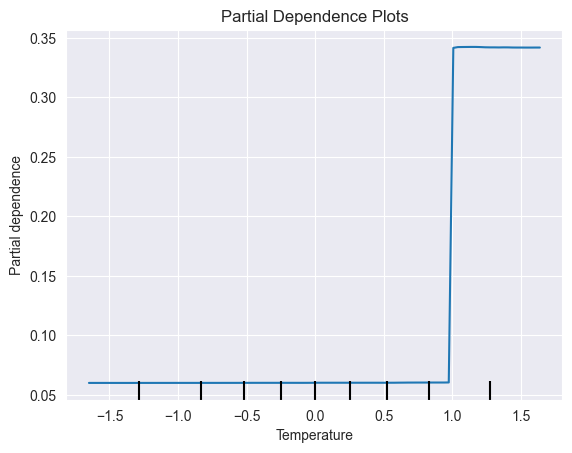

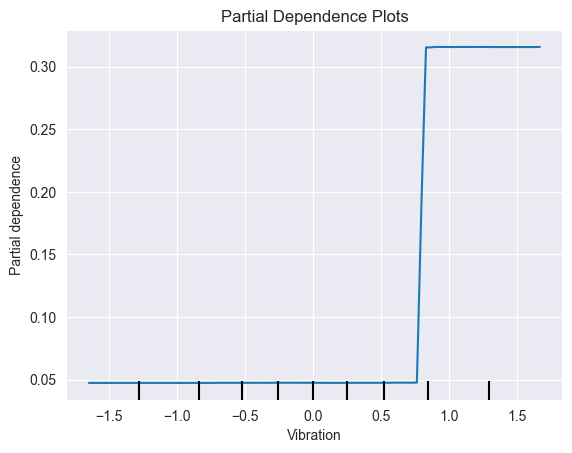

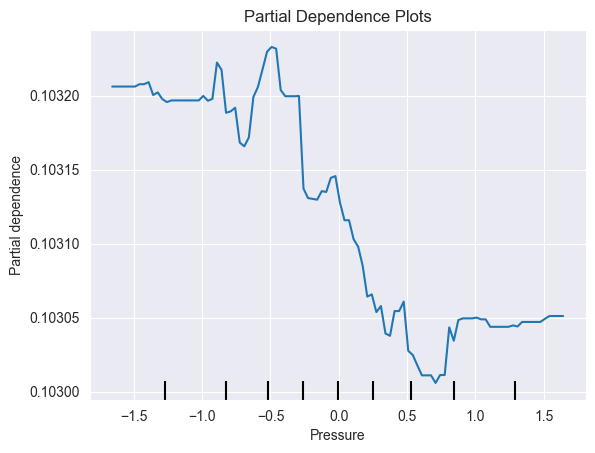

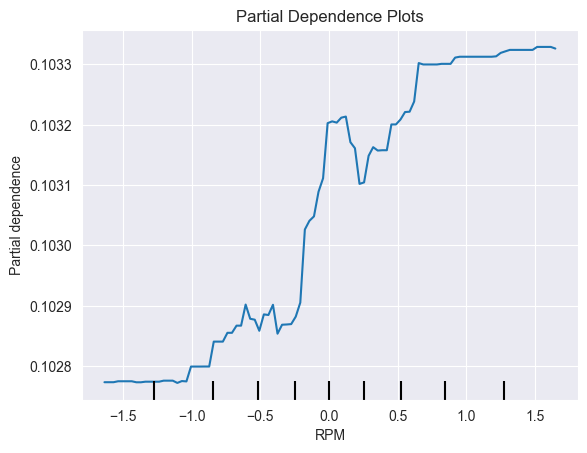

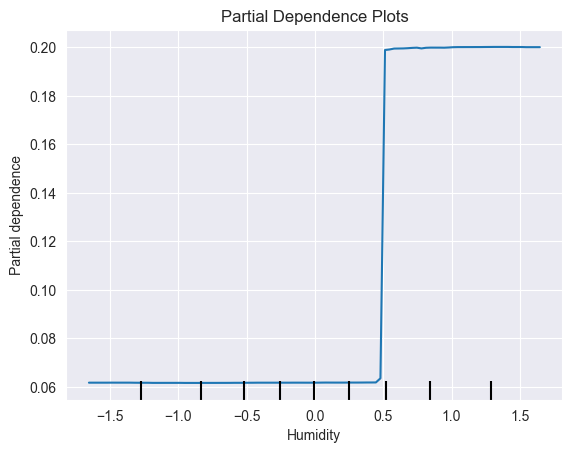

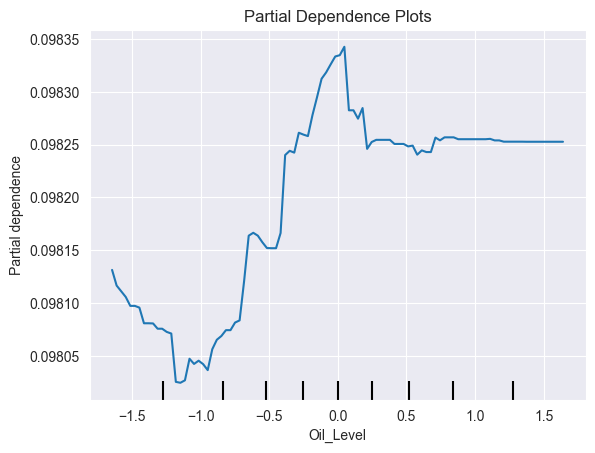

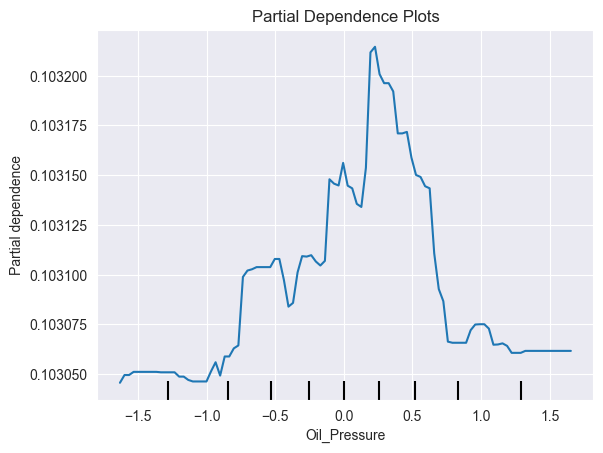

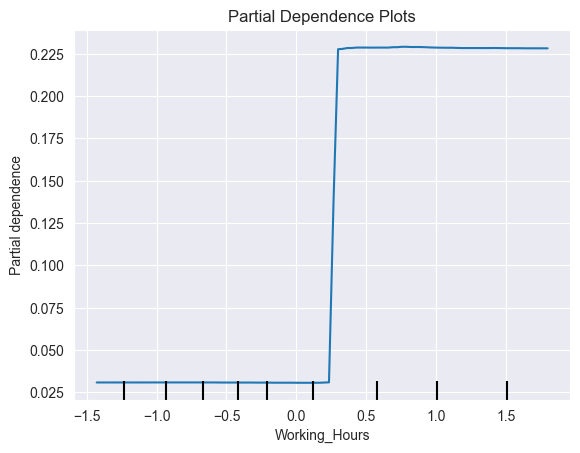

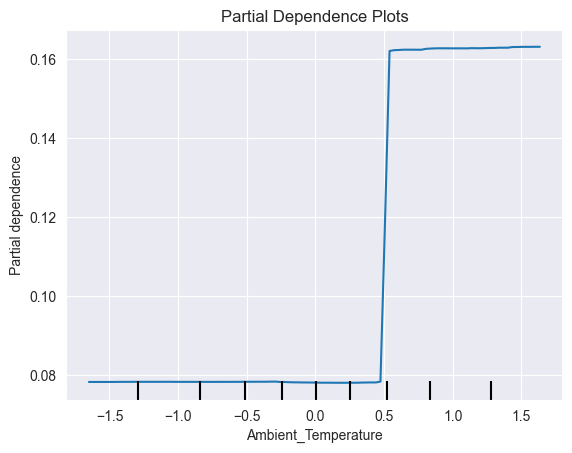

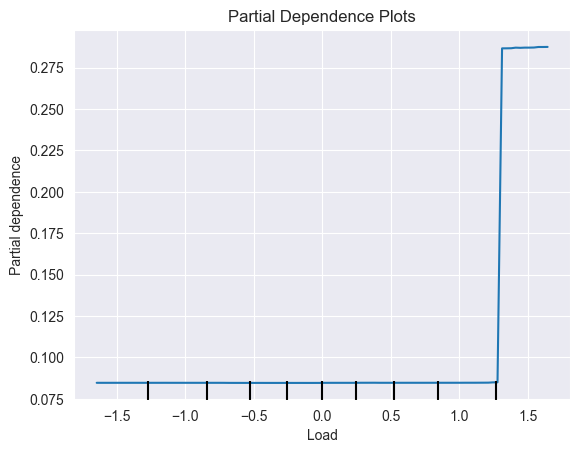

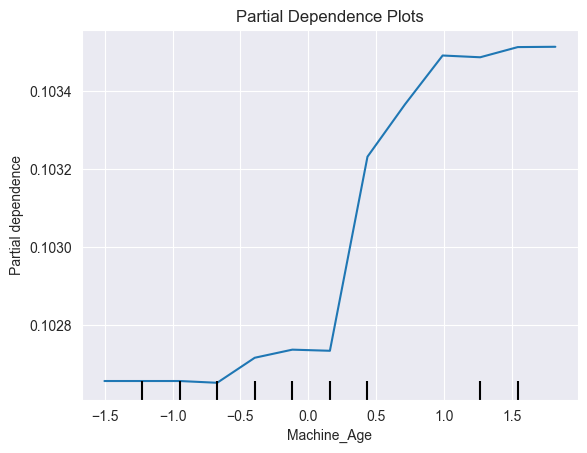

In [97]:
# Cechy, dla których będzie przeprowadzony PDP
features = ['Temperature', 'Vibration', 'Pressure', 'RPM', 'Humidity', 'Oil_Level', 'Oil_Pressure', 'Working_Hours', 'Ambient_Temperature', 'Load', 'Machine_Age']

for feature in features:
    display = PartialDependenceDisplay.from_estimator(
        model, X_train_scaled, [feature], feature_names=X.columns
    )

    plt.title('Partial Dependence Plots')
    plt.show()


##### Podsumowanie wyników:

1. Temperature, Vibration, Humidity, Working Hours, Ambient Temperature, Load, Machine Age:
- Cechy te wykazują skokowy wzrost w zależności od wartości tych zmiennych, wskazując na ich istotny wpływ na przewidywanie ryzyka awarii.
- Dla zmiennych takich jak Temperature, Vibration, Humidity, Working Hours, Ambient Temperature, Load, i Machine Age występują nieliniowe zależności - przy przekroczeniu pewnych progów (np. wyższe temperatury, większe wibracje, czy starszy wiek maszyny) ryzyko awarii gwałtownie rośnie.
- Machine Age wydaje się mieć duży wpływ na ryzyko awarii – starsze maszyny mają znacznie wyższe ryzyko awarii, co może sugerować konieczność zwiększenia częstotliwości przeglądów i konserwacji w miarę starzenia się maszyn.
2. Pressure, RPM, Oil Level, Oil Pressure:
- Dla zmiennych takich jak Pressure, RPM, Oil Level i Oil Pressure obserwujemy bardziej stopniowe zmiany, co może sugerować mniejsze, ale ciągłe oddziaływanie tych cech na ryzyko awarii.
- Zmienne takie jak Pressure i Oil Pressure wydają się mieć delikatniejsze zmiany, co wskazuje na możliwość optymalizacji i utrzymywania tych parametrów w bezpiecznym zakresie, aby zminimalizować ryzyko awarii.

##### Wnioski:

- Na podstawie wyników analizy PDP, wiek maszyny (Machine Age) oraz parametry takie jak temperatura, wibracje, wilgotność oraz obciążenie są kluczowymi zmiennymi predykcyjnymi w modelu.
- Maszyny starsze oraz te, które pracują w wyższych temperaturach, z wyższymi wibracjami i obciążeniem, mają wyższe ryzyko awarii.
- Proponowane działania prewencyjne mogą obejmować częstsze konserwacje i przeglądy maszyn starszych oraz monitorowanie parametrów takich jak temperatura, wibracje, obciążenie i ciśnienie oleju w czasie rzeczywistym.

#### SHAP (SHapley Additive exPlanations)

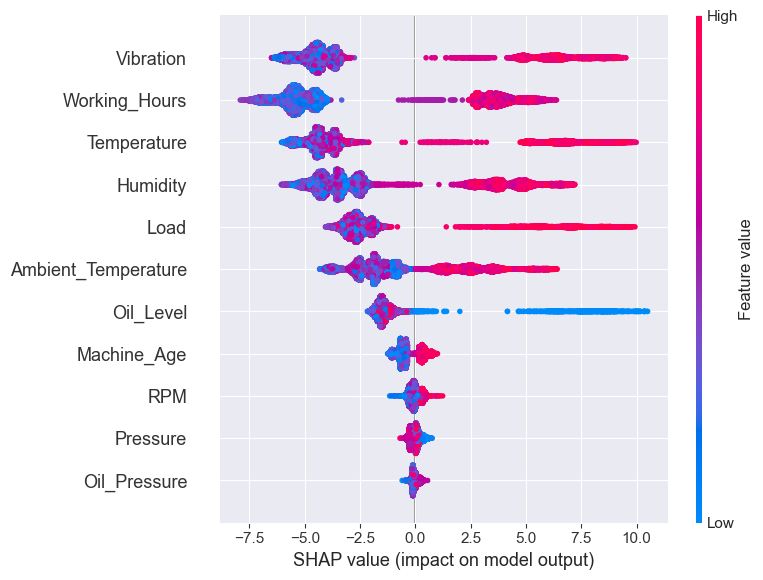

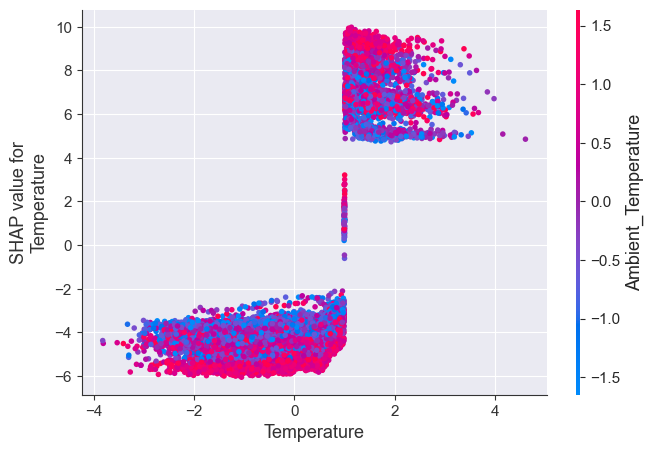

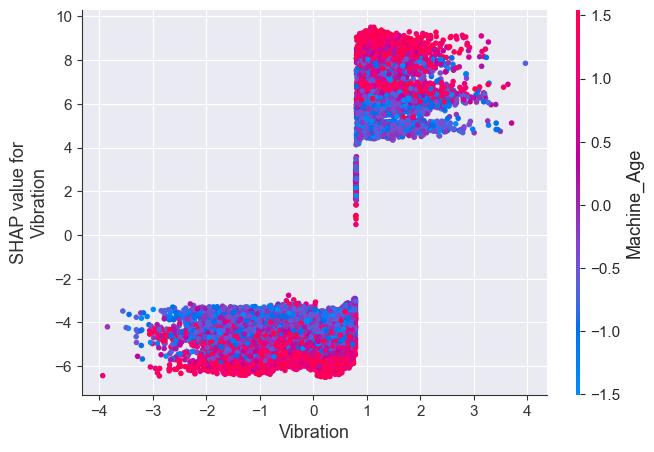

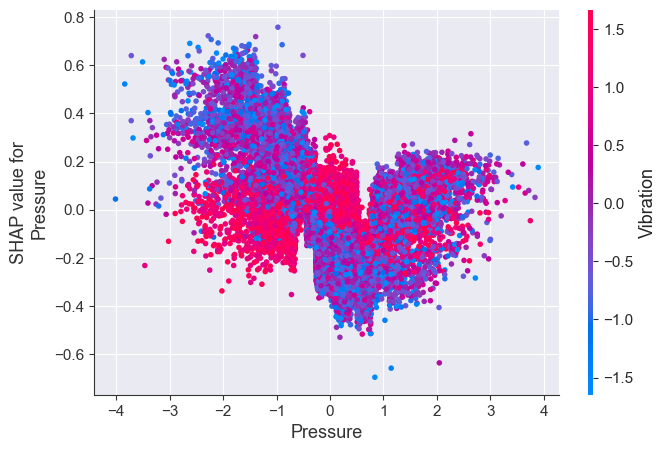

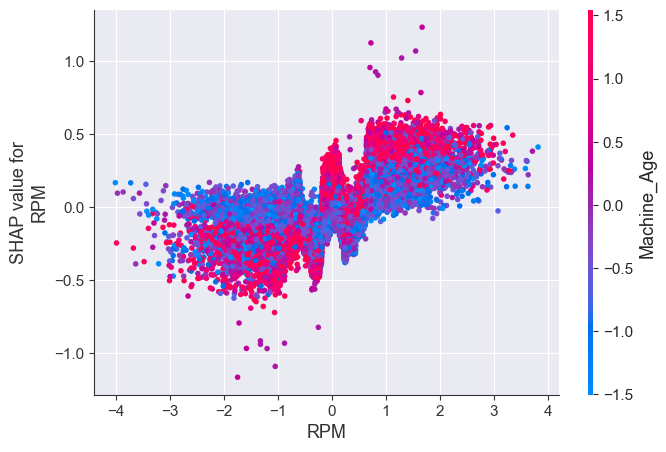

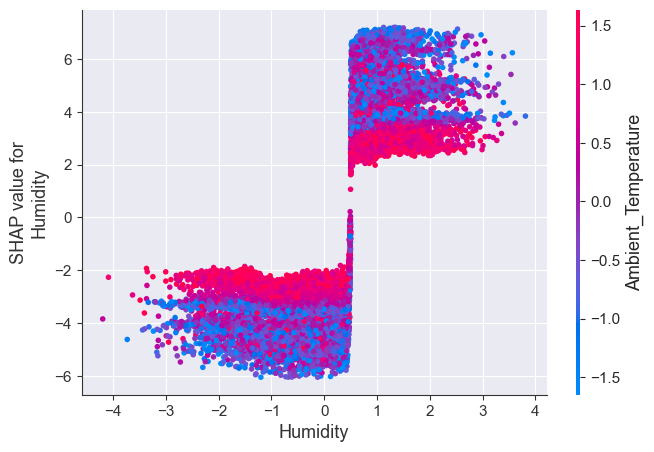

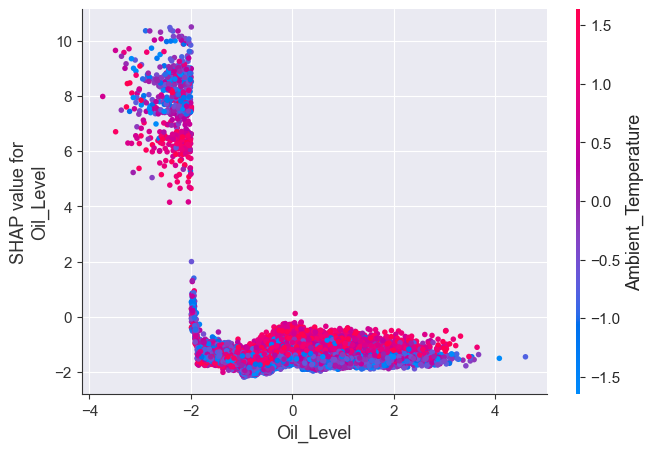

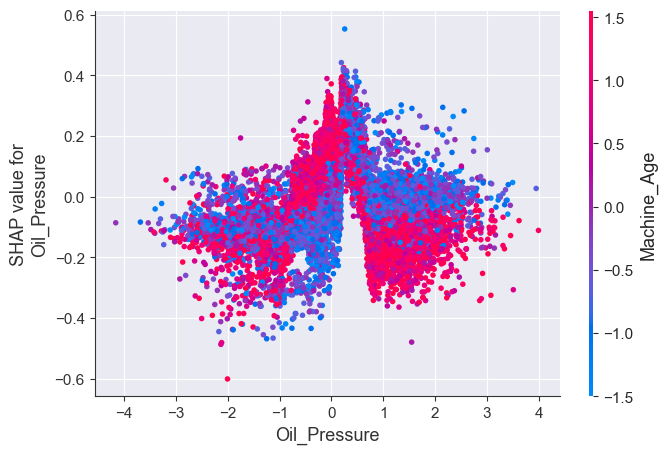

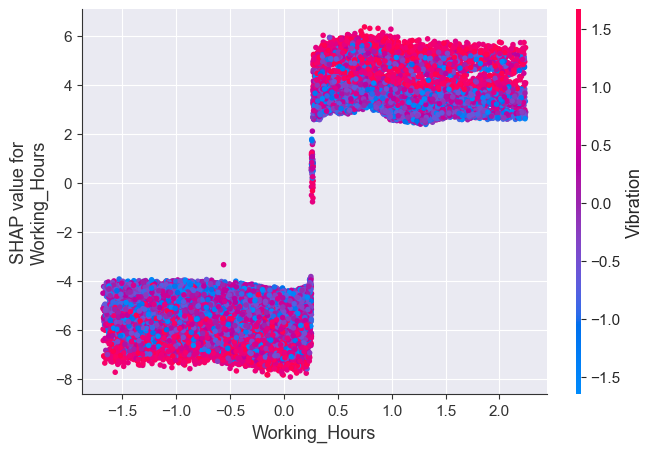

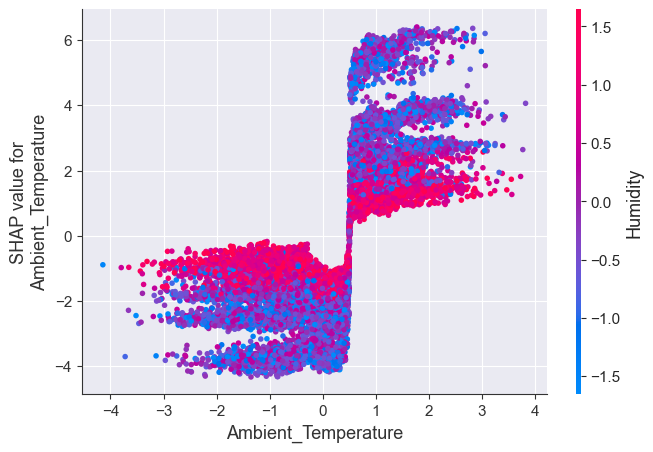

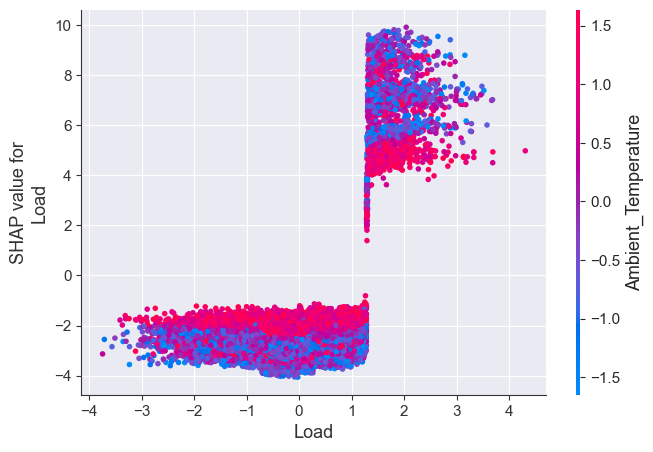

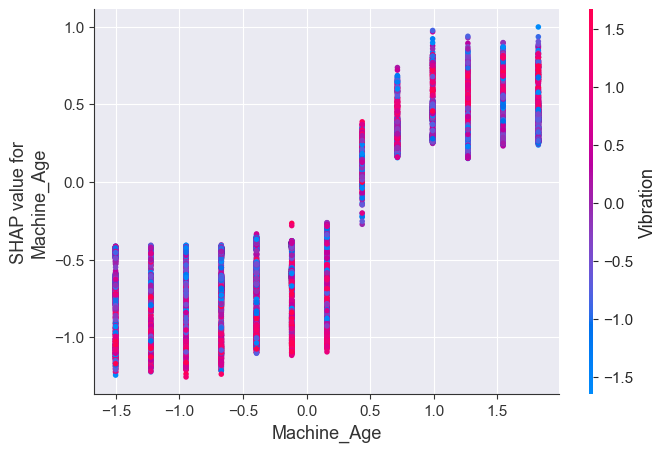

In [98]:
# Użycie SHAP do wyjaśnienia modelu
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_scaled)  # Używamy danych treningowych

# Wizualizacja wpływu cech na wynik modelu (summary plot)
shap.summary_plot(shap_values, X_train_scaled, feature_names=X.columns)

# Wizualizacja zależności SHAP (jak zmiana jednej cechy wpływa na wynik modelu)
features = ['Temperature', 'Vibration', 'Pressure', 'RPM', 'Humidity', 'Oil_Level', 'Oil_Pressure', 'Working_Hours', 'Ambient_Temperature', 'Load', 'Machine_Age']

for feature in features:
    shap.dependence_plot(feature, shap_values, X_train_scaled, feature_names=X.columns)



##### Podsumowanie analizy SHAP
W ramach analizy wpływu cech na wynik modelu przy użyciu metody SHAP, przeanalizowano, jak zmiany w poszczególnych zmiennych, takich jak temperatura, wibracje, wilgotność, wiek maszyny czy obciążenie, wpływają na przewidywania modelu.

###### Kluczowe obserwacje:
- Temperature i Vibration: Te cechy mają silny wpływ na wynik, zwłaszcza gdy ich wartości przekraczają określony próg. Wyższe temperatury i wibracje są silnie powiązane z wyższym ryzykiem awarii.
- Machine_Age: Wiek maszyny pokazuje wyraźny wzrost wpływu na wynik w miarę jego starzenia się. Starsze maszyny mają większy wpływ na prawdopodobieństwo awarii.
- Humidity i Oil_Level: Zmiany w wilgotności oraz poziomie oleju wykazują silny wpływ na wynik modelu w przypadku wartości ekstremalnych, zarówno bardzo niskich, jak i bardzo wysokich.
- Load: Wysokie obciążenie jest skorelowane z większym ryzykiem awarii, co sugeruje, że obciążenie może być istotnym czynnikiem w prognozowaniu awarii.
- Pressure i RPM: Obie te cechy wykazują zmienny wpływ na wynik, z wyraźnymi zmianami w rejonach określonych wartości, co wskazuje na ich znaczenie w kontekście monitorowania procesów.

##### Wnioski:
Na podstawie wyników analizy SHAP, można stwierdzić, że kluczowe zmienne w modelu to temperatura, wibracje, wiek maszyny, obciążenie oraz poziom wilgotności. Zmiany w tych cechach mają istotny wpływ na wynik modelu, a ich monitorowanie może pomóc w przewidywaniu awarii maszyn, co umożliwia podejmowanie działań prewencyjnych w celu ich uniknięcia.

#### Podsumowanie wpływu zmiennych

In [99]:
# Obliczenie wpływu cech na wynik modelu
feature_importance = np.abs(shap_values).mean(axis=0)  # Średni wpływ cech
feature_importance_df = pd.DataFrame(list(zip(X.columns, feature_importance)), columns=['Feature', 'Importance'])
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Wyświetlenie najważniejszych cech
print("Najważniejsze cechy w modelu:")
print(feature_importance_df)


Najważniejsze cechy w modelu:
                Feature  Importance
1             Vibration    4.888550
7         Working_Hours    4.800595
0           Temperature    4.653830
4              Humidity    3.802688
9                  Load    2.986391
8   Ambient_Temperature    2.125086
5             Oil_Level    1.582693
10          Machine_Age    0.556060
3                   RPM    0.190182
2              Pressure    0.159144
6          Oil_Pressure    0.109362


##### Wyniki analizy wpływu cech:

Na podstawie analizy SHAP obliczono wpływ poszczególnych cech na wynik modelu. Cechy zostały posortowane według średniego wpływu na decyzje podejmowane przez model. Najważniejsze cechy to Temperature, Vibration oraz Working_Hours, które wykazały najwyższy wpływ na przewidywanie awarii maszyn. Z kolei cechy takie jak Oil_Pressure oraz Pressure miały mniejszy wpływ na model, co sugeruje, że ich zmiana miała mniejszy wpływ na końcową decyzję modelu.

## Podsumowanie analizy
W ramach przeprowadzonej analizy, zastosowano różne techniki, takie jak analiza zależności SHAP, analiza wrażliwości cech oraz metody wizualizacji, aby zrozumieć, które cechy mają największy wpływ na przewidywania modelu w kontekście awarii maszyn. Zidentyfikowano kluczowe cechy, takie jak Temperature, Vibration oraz Working_Hours, które mają największy wpływ na wynik modelu, wskazując na ich znaczenie w predykcji awarii. Dodatkowo, przeprowadzono optymalizację hiperparametrów modelu oraz cross-validation, co pozwoliło uzyskać wyniki o wysokiej precyzji, szczególnie w przypadku modelu Gradient Boosting (XGBoost), który wykazał najlepsze wyniki.

### Wnioski

#### Kluczowe czynniki ryzyka awarii:
Cechy takie jak temperatura, wibracje oraz godziny pracy wykazały się jako najważniejsze w przewidywaniu awarii maszyn. Zmiany w tych parametrach mogą znacząco wpłynąć na wyniki modelu, co sugeruje, że są one kluczowe dla monitorowania stanu maszyn i prognozowania awarii.

#### Optymalizacja modelu:
Przeprowadzenie optymalizacji hiperparametrów i zastosowanie cross-validation pozwoliło na osiągnięcie bardzo wysokiej jakości modelu predykcyjnego. Model XGBoost, po optymalizacji, osiągnął F1-score na poziomie 0.99, co wskazuje na wysoką skuteczność przewidywań.

#### Analiza wpływu cech:
Analiza SHAP i wykresy zależności potwierdziły, że zmiany w określonych cechach, takich jak temperatura czy wibracje, mają duży wpływ na decyzje modelu, co może być użyteczne w monitorowaniu maszyn i planowaniu działań prewencyjnych.

#### Zalecenia
- Monitorowanie kluczowych parametrów: Organizacja powinna szczególnie monitorować parametry takie jak Temperature, Vibration oraz Working_Hours, ponieważ mają one największy wpływ na ryzyko awarii. Regularne śledzenie tych zmiennych pozwala na szybsze wykrywanie potencjalnych problemów.

- Optymalizacja harmonogramów konserwacji: W oparciu o wyniki analizy, można zoptymalizować harmonogramy konserwacji maszyn, koncentrując się na urządzeniach, które wykazują najwyższe wartości w kluczowych parametrach, takich jak temperatura i wibracje.

- Automatyzacja monitorowania: Zastosowanie modelu predykcyjnego w systemach monitorowania maszyn pozwala na automatyczne wykrywanie anomalii w czasie rzeczywistym, co umożliwia szybsze reagowanie na potencjalne awarie.

- Zwiększenie efektywności działań prewencyjnych: Analiza wpływu cech i SHAP może posłużyć do lepszego zrozumienia, które czynniki mają największy wpływ na awarie, co może pomóc w podjęciu bardziej ukierunkowanych działań prewencyjnych, takich jak dostosowanie parametrów pracy maszyn do bezpieczniejszych wartości.

### Podsumowanie dla organizacji
Dzięki przeprowadzonej analizie i optymalizacji modelu predykcyjnego, organizacja może lepiej zarządzać ryzykiem awarii maszyn. Odpowiednie monitorowanie kluczowych zmiennych, takich jak temperatura, wibracje i godziny pracy, pozwoli na szybsze reagowanie na problemy oraz bardziej precyzyjne planowanie konserwacji, co w efekcie wpłynie na zwiększenie efektywności operacyjnej i zmniejszenie kosztów związanych z awariami maszyn.